In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [26]:
cinic_directory = 'C:/Users/Dell/.cache/kagglehub/datasets/mengcius/cinic10/versions/1'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
cinic_train = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
    batch_size=128, shuffle=True)
cinic_valid = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/valid',
    	transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
    batch_size=128, shuffle=False)

torch.Size([3, 32, 32])


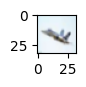

Etykieta: 0


In [22]:
cinic_mean_tensor = torch.tensor(cinic_mean).view(3, 1, 1)
cinic_std_tensor = torch.tensor(cinic_std).view(3, 1, 1)

def imshow(img):
    print(img.size())
    img = img * cinic_std_tensor + cinic_mean_tensor  # Odwracamy normalizację
    npimg = img.numpy()
    plt.figure(figsize=(0.5,0.5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Pobranie batcha obrazów
data_iter = iter(cinic_train)
images, labels = next(data_iter)

# Wyświetlenie pierwszego obrazu
imshow(images[0])
print("Etykieta:", labels[0].item())

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Redukcja rozmiaru 32x32 -> 16x16
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Redukcja rozmiaru 16x16 -> 8x8
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # CINIC-10 ma 10 klas
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [33]:
class VGGStyleCNN(nn.Module):
    def __init__(self):
        super(VGGStyleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Redukcja rozmiaru 32x32 -> 16x16

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Redukcja rozmiaru 16x16 -> 8x8

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Redukcja rozmiaru 8x8 -> 4x4

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Redukcja rozmiaru 4x4 -> 2x2
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)  # CINIC-10 ma 10 klas
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGGStyleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(cinic_train, desc=f"Epoka {epoch+1}/{num_epochs}")

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Obliczanie dokładności na zbiorze treningowym
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(cinic_train)
    accuracy = 100 * correct / total
    print(f"📊 Epoka [{epoch+1}/{num_epochs}], Strata: {avg_loss:.4f}, Dokładność: {accuracy:.2f}%")

print("✅ Trenowanie zakończone!")

Epoka 1/2: 100%|██████████| 704/704 [05:52<00:00,  1.99it/s, loss=0.472]


📊 Epoka [1/2], Strata: 0.4632, Dokładność: 83.46%


Epoka 2/2: 100%|██████████| 704/704 [07:30<00:00,  1.56it/s, loss=0.318]

📊 Epoka [2/2], Strata: 0.4222, Dokładność: 84.86%
✅ Trenowanie zakończone!


In [42]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in cinic_valid:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Dokładność na zbiorze walidacyjnym: {100 * correct / total:.2f}%")

Dokładność na zbiorze walidacyjnym: 73.87%
